Engineering new features...
New features created successfully!
Here are the new columns:
            Timestamp  hour  hour_sin  hour_cos  rain_wind_interaction  \
0 2021-01-01 01:00:00     1  0.258819  0.965926                    0.0   
1 2021-01-01 02:00:00     2  0.500000  0.866025                    0.0   
2 2021-01-01 03:00:00     3  0.707107  0.707107                    0.0   
3 2021-01-01 04:00:00     4  0.866025  0.500000                    0.0   
4 2021-01-01 05:00:00     5  0.965926  0.258819                    0.0   

   wind_chill  
0       -15.3  
1       -10.7  
2        -9.8  
3        -9.2  
4        -8.9  

Correlation of NEW features with Casualties:
Casualties               1.000000
hour_sin                 0.049649
hour_cos                 0.021183
rain_wind_interaction    0.009975
wind_chill              -0.386129
Name: Casualties, dtype: float64


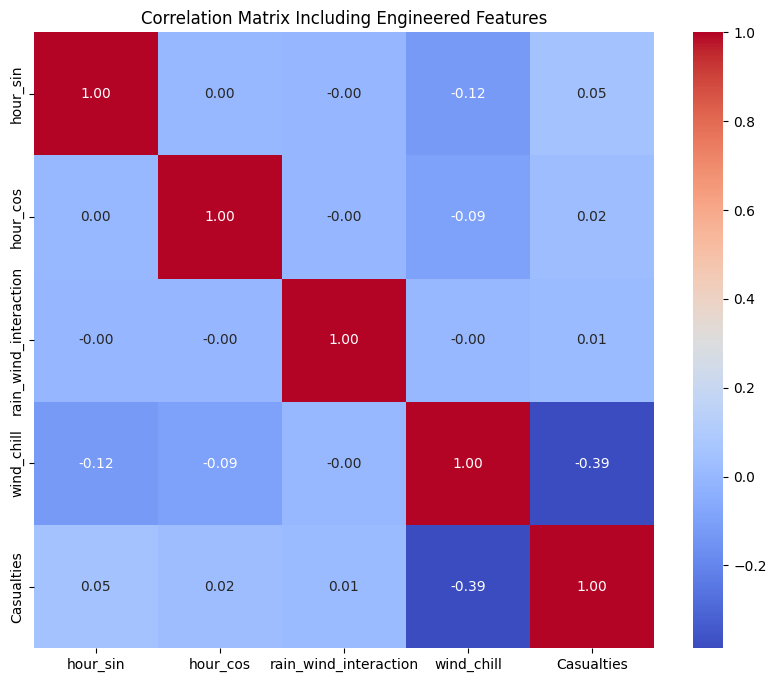

In [ ]:
# In your EDA.ipynb notebook

# =================================================================
# Cell 1: Load and Basic Prep
# =================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'kma_weather_data.csv'
column_names = [
    'Station ID', 'Station Name', 'Timestamp', 'Mean temperature',
    'Daily precipitation', 'Mean wind speed', 'Mean relative humidity',
    'Deepest snow cover on a day', 'Deepest snowfall on the day',
    'Phenomenon number', 'Mean ground temperature', '5cm ground temperature',
    '10cm ground temperature', '20cm ground temperature', '30cm ground temperature'
]
df = pd.read_csv(
    file_path, encoding='euc-kr', header=None,
    skiprows=1, names=column_names
)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)
df.fillna(0, inplace=True) # Fill NaNs for calculation purposes
print("Data loaded and prepped successfully.")

# =================================================================
# Cell 2: Engineer New, Advanced Features
# =================================================================
print("\nEngineering new features...")

# 1. Cyclical Hour Features
df['hour'] = df['Timestamp'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)

# 2. Wind x Rain Interaction
df['rain_wind_interaction'] = df['Daily precipitation'] * df['Mean wind speed']

# 3. Wind Chill
df['wind_chill'] = df['Mean temperature'] - (df['Mean wind speed'] * 2)

print("New features created successfully!")
print("Here are the new columns:")
print(df[['Timestamp', 'hour', 'hour_sin', 'hour_cos', 'rain_wind_interaction', 'wind_chill']].head())


# =================================================================
# Cell 3: Test the New Features with Correlation Analysis
# =================================================================
print("\n--- Testing Engineered Features ---")
# Create our rule-based casualties to test against
base_risk = 0.1
risk_score = base_risk
risk_score += (df['Deepest snow cover on a day'] > 0) * 8.0
risk_score += (df['Mean temperature'] < 0) * 1.5
risk_score += (df['Daily precipitation'] > 30) * 4.0
risk_score += (df['Mean wind speed'] > 15) * 2.0
y = pd.Series(np.random.poisson(lam=risk_score), name='Casualties')

# Create a temporary DataFrame for this test
test_df = df.copy()
test_df['Casualties'] = y

# Create a new correlation matrix INCLUDING our new features
new_features_to_test = ['hour_sin', 'hour_cos', 'rain_wind_interaction', 'wind_chill', 'Casualties']
correlation_matrix_new = test_df[new_features_to_test].corr()

print("\nCorrelation of NEW features with Casualties:")
print(correlation_matrix_new['Casualties'].sort_values(ascending=False))

# Visualize the new correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_df[new_features_to_test].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Including Engineered Features")
plt.show()

# =================================================================
# Cell 4: Replicating the Paper's Categorical Analysis Plots
# =================================================================
print("\n--- Generating dual-axis plots to analyze categorical features ---")

# First, create the contextual categorical features (season, time, etc.)
df['day_of_week'] = df['Timestamp'].dt.day_name()
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'
df['season'] = df['Timestamp'].dt.month.apply(get_season)
def get_accident_time(hour):
    if 6 <= hour < 10: return 'Morning Rush'
    elif 10 <= hour < 16: return 'Midday'
    elif 16 <= hour < 20: return 'Evening Rush'
    else: return 'Night'
df['accident_time'] = df['Timestamp'].dt.hour.apply(get_accident_time)
railway_types = ['Main Line', 'Branch Line', 'Metro', 'Freight Line']
df['railway_classification'] = np.random.choice(railway_types, size=len(df), p=[0.4, 0.3, 0.2, 0.1])

# Create a final DataFrame for these plots
eda_df = df.copy()
eda_df['Casualties'] = y

# --- Plot (a): Analysis by Season ---
season_data = eda_df.groupby('season')['Casualties'].agg(['count', 'sum']).reindex(['Summer', 'Fall', 'Winter', 'Spring'])
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(season_data.index, season_data['count'], color='tab:blue', alpha=0.7, label='No. of Observations')
ax1.set_xlabel('Season', fontsize=12)
ax1.set_ylabel('No. of Observations', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(season_data.index, season_data['sum'], color='tab:red', marker='o', linestyle='-', label='Casualty')
ax2.set_ylabel('Casualty (Sum)', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.title('Observations and Casualties by Season', fontsize=16)
fig.tight_layout()
plt.show()

# --- Plot (b): Analysis by Accident Time ---
time_data = eda_df.groupby('accident_time')['Casualties'].agg(['count', 'sum']).reindex(['Night', 'Morning Rush', 'Midday', 'Evening Rush'])
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(time_data.index, time_data['count'], color='tab:blue', alpha=0.7)
ax1.set_xlabel('Accident Time', fontsize=12)
ax1.set_ylabel('No. of Observations', color='tab:blue', fontsize=12)
ax2 = ax1.twinx()
ax2.plot(time_data.index, time_data['sum'], color='tab:red', marker='o', linestyle='-')
ax2.set_ylabel('Casualty (Sum)', color='tab:red', fontsize=12)
plt.title('Observations and Casualties by Accident Time', fontsize=16)
fig.tight_layout()
plt.show()

# --- Plot (c): Analysis by Day of the Week ---
day_order = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
day_data = eda_df.groupby('day_of_week')['Casualties'].agg(['count', 'sum']).reindex(day_order)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(day_data.index, day_data['count'], color='tab:blue', alpha=0.7)
ax1.set_xlabel('Day of the Week', fontsize=12)
ax1.set_ylabel('No. of Observations', color='tab:blue', fontsize=12)
plt.xticks(rotation=45)
ax2 = ax1.twinx()
ax2.plot(day_data.index, day_data['sum'], color='tab:red', marker='o', linestyle='-')
ax2.set_ylabel('Casualty (Sum)', color='tab:red', fontsize=12)
plt.title('Observations and Casualties by Day of the Week', fontsize=16)
fig.tight_layout()
plt.show()

# --- Plot (d): Analysis by Railway Classification ---
rail_data = eda_df.groupby('railway_classification')['Casualties'].agg(['count', 'sum'])
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(rail_data.index, rail_data['count'], color='tab:blue', alpha=0.7)
ax1.set_xlabel('Railway Classification', fontsize=12)
ax1.set_ylabel('No. of Observations', color='tab:blue', fontsize=12)
ax2 = ax1.twinx()
ax2.plot(rail_data.index, rail_data['sum'], color='tab:red', marker='o', linestyle='-')
ax2.set_ylabel('Casualty (Sum)', color='tab:red', fontsize=12)
plt.title('Observations and Casualties by Railway Classification', fontsize=16)
fig.tight_layout()
plt.show()

In [6]:
# =================================================================
# Cell 1: Import All Necessary Libraries
# =================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os  # Needed to check for the model file
import tensorflow as tf # Needed to load the Keras model

# Import the specific tools needed for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

print("All libraries imported.")

All libraries imported.


In [7]:
# =================================================================
# Cell 2: Load Data and Fabricate Features/Target
# =================================================================
file_path = 'kma_weather_data.csv'
column_names = [
    'Station ID', 'Station Name', 'Timestamp', 'Mean temperature',
    'Daily precipitation', 'Mean wind speed', 'Mean relative humidity',
    'Deepest snow cover on a day', 'Deepest snowfall on the day',
    'Phenomenon number', 'Mean ground temperature', '5cm ground temperature',
    '10cm ground temperature', '20cm ground temperature', '30cm ground temperature'
]
df = pd.read_csv(
    file_path, encoding='euc-kr', header=None,
    skiprows=1, names=column_names
)

# --- Feature Engineering & Data Creation (Same as in run_model.py) ---
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)
df['day_of_week'] = df['Timestamp'].dt.day_name()
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'
df['season'] = df['Timestamp'].dt.month.apply(get_season)
def get_accident_time(hour):
    if 6 <= hour < 10: return 'Morning Rush'
    elif 10 <= hour < 16: return 'Midday'
    elif 16 <= hour < 20: return 'Evening Rush'
    else: return 'Night'
df['accident_time'] = df['Timestamp'].dt.hour.apply(get_accident_time)
railway_types = ['Main Line', 'Branch Line', 'Metro', 'Freight Line']
df['railway_classification'] = np.random.choice(railway_types, size=len(df), p=[0.4, 0.3, 0.2, 0.1])
df.fillna(0, inplace=True)
df['wind_chill'] = df['Mean temperature'] - (df['Mean wind speed'] * 2)

# --- Rule-Based Casualty Generation (Use the final "dramatic" version) ---
np.random.seed(42)
base_risk = 0.1
risk_score = base_risk
risk_score += (df['Deepest snow cover on a day'] > 0) * 8.0
risk_score += (df['season'] == 'Winter') * 1.5
risk_score += (df['Daily precipitation'] > 30) * 4.0
risk_score += (df['Mean wind speed'] > 15) * 2.0
y = pd.Series(np.random.poisson(lam=risk_score), name='Casualties')

# --- Define the final X and y ---
numerical_features = [
    'Mean temperature', 'Daily precipitation', 'Mean wind speed',
    'Mean relative humidity', 'Deepest snow cover on a day', 'wind_chill'
]
categorical_features = ['day_of_week', 'season', 'accident_time', 'railway_classification']
X = df[numerical_features + categorical_features]

print("Data loaded and all features/target created successfully.")

Data loaded and all features/target created successfully.


In [8]:
# =================================================================
# Cell 3: Preprocess the Data (Split and Transform)
# =================================================================
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the preprocessor on the training data and transform both sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Data has been split and preprocessed.")
print(f"Shape of X_test_processed: {X_test_processed.shape}")

Data has been split and preprocessed.
Shape of X_test_processed: (249533, 25)



--- Calculating Feature Importance using Permutation Importance ---
Running Permutation Importance on the test set...
7798/7798 ━━━━━━━━━━━━━━━━━━━━ 4s 504us/step


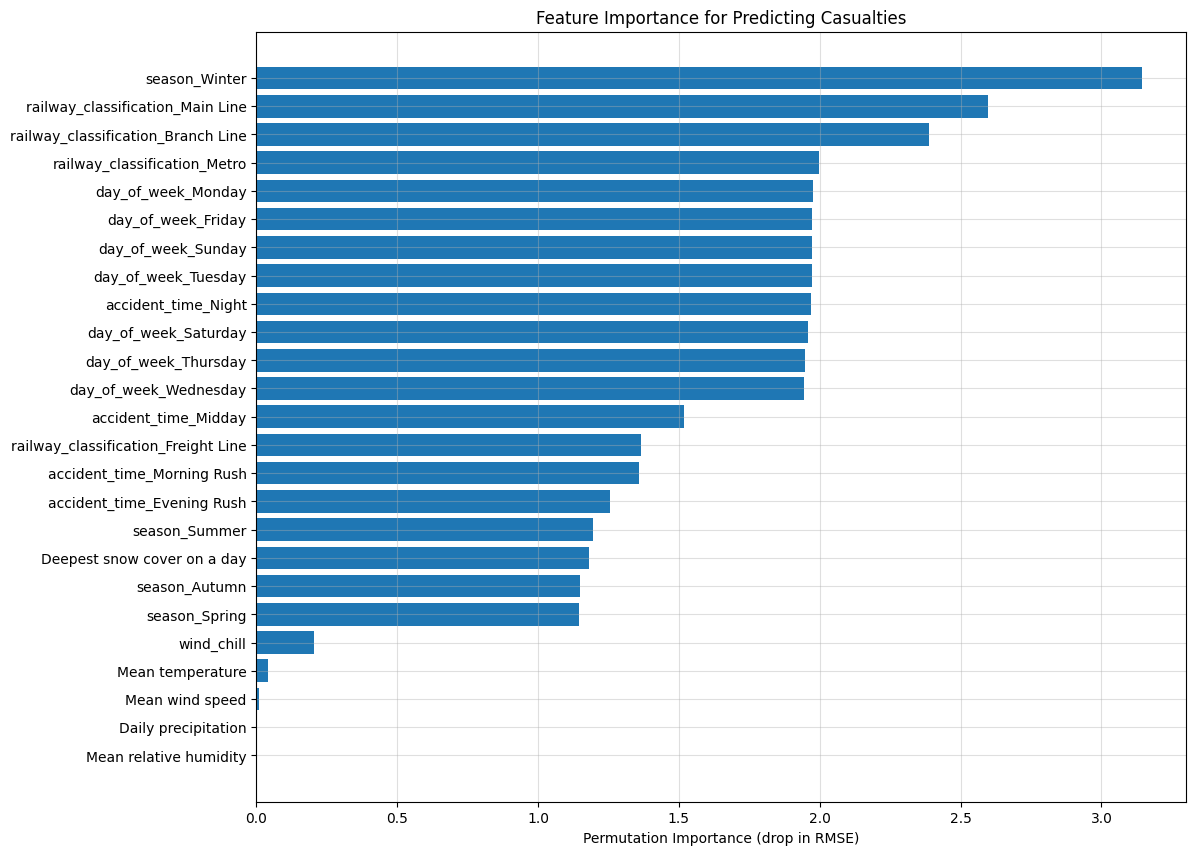

In [9]:
# ==============================================================================
# Cell 4: Generate the Feature Importance Plot (Corrected Version 2)
# ==============================================================================
print("\n--- Calculating Feature Importance using Permutation Importance ---")

# We need a trained model for this.
from sklearn.inspection import permutation_importance
from scikeras.wrappers import KerasRegressor

MODEL_FILENAME = 'weather_dnn_regression_v3.keras'

if os.path.exists(MODEL_FILENAME):
    # Load the trained Keras model
    keras_model = tf.keras.models.load_model(MODEL_FILENAME)
    
    # Wrap the Keras model to make it compatible with Scikit-learn
    sklearn_model = KerasRegressor(model=keras_model)

    # ### NEW: Perform a "dummy" fit to satisfy Scikit-learn's check ###
    # We "fit" it for zero epochs. This does not retrain the model.
    # It just sets the internal state of the wrapper to "fitted".
    sklearn_model.fit(X_train_processed, y_train, epochs=0)

    print("Running Permutation Importance on the test set...")
    
    # Run Permutation Importance (this will now work)
    result = permutation_importance(
        sklearn_model,
        X_test_processed,
        y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
    )
    
    # Get the feature names after one-hot encoding
    feature_names = list(preprocessor.named_transformers_['num'].get_feature_names_out()) + \
                    list(preprocessor.named_transformers_['cat'].get_feature_names_out())

    # Create a DataFrame for easy plotting
    importance_df = pd.DataFrame(
        {'feature': feature_names, 'importance': result.importances_mean}
    ).sort_values('importance', ascending=True)

    # Plot the results
    plt.figure(figsize=(12, 10))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel("Permutation Importance (drop in RMSE)")
    plt.title("Feature Importance for Predicting Casualties")
    plt.grid(alpha=0.4)
    plt.show()

else:
    print(f"Model file '{MODEL_FILENAME}' not found. Please train the main model first.")


--- Plotting Training Histories to Compare Dropout Effect ---


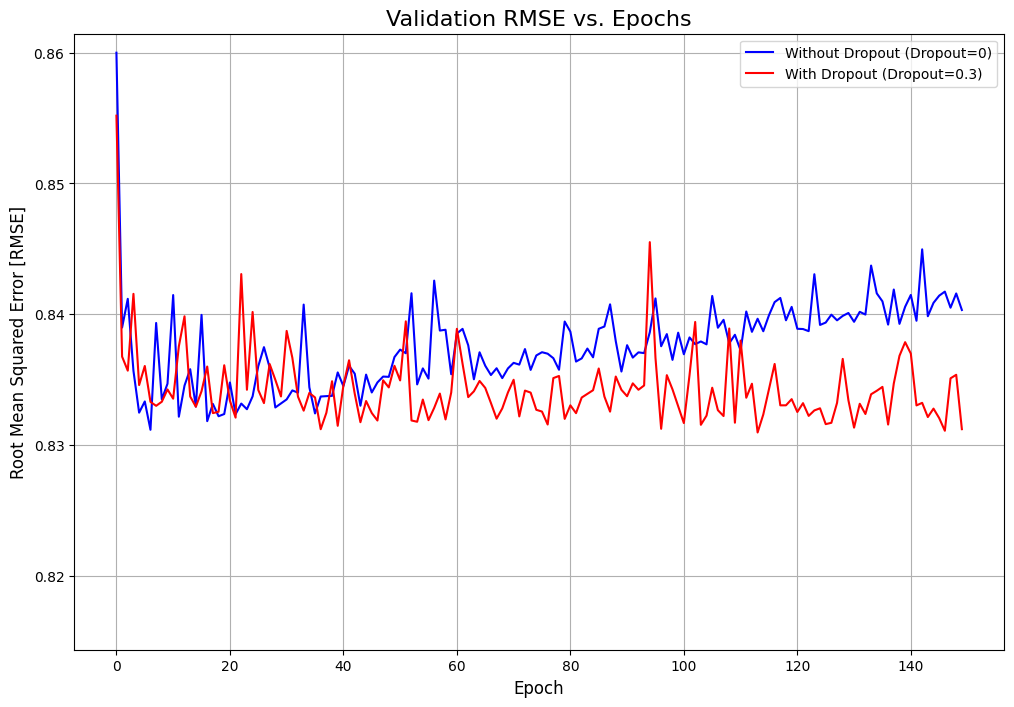

In [10]:
# ==============================================================================
# Replicating the Evaluation vs. Epochs Plot (Figure 6 from the paper)
# ==============================================================================
print("\n--- Plotting Training Histories to Compare Dropout Effect ---")

try:
    # Load the saved history data from your two separate training runs
    history_with_dropout = pd.read_csv('history_with_dropout.csv')
    history_without_dropout = pd.read_csv('history_without_dropout.csv')

    # Calculate RMSE from the 'val_loss' (which is MSE)
    rmse_with_dropout = np.sqrt(history_with_dropout['val_loss'])
    rmse_without_dropout = np.sqrt(history_without_dropout['val_loss'])

    plt.figure(figsize=(12, 8))

    # Plot the RMSE for both models
    plt.plot(rmse_without_dropout, label='Without Dropout (Dropout=0)', color='blue')
    plt.plot(rmse_with_dropout, label='With Dropout (Dropout=0.3)', color='red')
    
    plt.title('Validation RMSE vs. Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Root Mean Squared Error [RMSE]', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=min(rmse_with_dropout.min(), rmse_without_dropout.min()) * 0.98) # Adjust y-axis for better visibility
    plt.show()

except FileNotFoundError:
    print("History files ('history_with_dropout.csv', 'history_without_dropout.csv') not found.")
    print("Please follow the steps to run the training script twice (with and without dropout) to generate these files first.")